<a href="https://colab.research.google.com/github/jakechinmk/data_science/blob/main/give_me_credit/notebook/04_feature_engineering_lr_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
- Conduct feature cleaning and feature engineering
- Fit into same model again

# Setup

In [90]:
!pip install -q optbinning dataprep

## Import Libraries

In [91]:
import numpy as np
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import xgboost as xgb

from dataprep.eda import create_report, plot_diff
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold

from optbinning import BinningProcess, Scorecard
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks

from yellowbrick.classifier import ClassificationReport, ROCAUC 
from yellowbrick.classifier import PrecisionRecallCurve, DiscriminationThreshold
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.model_selection import CVScores
from yellowbrick.model_selection import FeatureImportances

## Global Configuration

In [92]:
TRAIN_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/03-baseline_model-train_df.csv'
TEST_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/03-baseline_model-test_df.csv'
VALID_PATH = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/valid_df.csv'
OUTPUT_DIR = '/content/drive/MyDrive/Colab Notebooks/Paidy/output/'
OUTPUT = True
SEED = 123
TEST_SIZE = 0.3

## Global Function

In [93]:
def classifier_evaluation(model, x_train, y_train, x_test, y_test, cv, scoring):
  fig, axes = plt.subplots(3, 2, figsize=(10, 8))

  visualizer_list = [
      ClassificationReport(model, ax=axes[0][0]),
      ConfusionMatrix(model, ax=axes[0][1]),
      ROCAUC(model, ax=axes[1][0]),
      PrecisionRecallCurve(model, ax=axes[1][1]),
      DiscriminationThreshold(model, ax=axes[2][0]),
      CVScores(model, cv=cv, scoring=scoring, ax=axes[2][1])
  ]

  for i, viz in enumerate(visualizer_list):
    viz.fit(x_train, y_train)
    if i < 4:
      viz.score(x_test, y_test)
    viz.finalize()
  plt.show()

In [94]:
def bucket_evaluation(y_pred_prob:np.ndarray, y_true:pd.Series, bucket:int) -> pd.DataFrame:
    """Evaluate model based on bucket defined

    Args:
        y_pred_prob (np.ndarray): probability predicted using model.
        y_true (pd.Series): true label
        bucket (int): number of bucket.

    Returns:
        pd.DataFrame: Aggregated performance. Similar like CAP graph
    """
    df = pd.DataFrame({
        'pred':y_pred_prob,
        'true':y_true
        })
    df.loc[:, 'bins'], limit = pd.qcut(df.loc[:, 'pred'], 
                                       q=bucket, 
                                       labels=range(1, bucket+1), 
                                       retbins=True
                                       )
    rename_dict = {'sum':'event',
                   'count':'total',
                   }
    agg_df = (df.groupby('bins', as_index=False)['true']
              .agg(['sum', 'count'])
              .rename(columns=rename_dict)
              )
    agg_df.loc[:, 'lower_limit'] = limit[:-1]
    agg_df.loc[:, 'upper_limit'] = limit[1:]
    agg_df.loc[:, 'cumulative_event'] = agg_df.loc[:, 'event'].cumsum()
    agg_df.loc[:, 'cumulative_total'] = agg_df.loc[:, 'total'].cumsum()
    agg_df.loc[:, 'capture_rate'] = (agg_df.loc[:, 'cumulative_event'] 
                                     / agg_df.loc[:, 'event'].sum()
                                     )
    agg_df.loc[:, 'event_rate'] = agg_df.loc[:, 'event'] / agg_df.loc[:, 'total']
    return agg_df

# Data
## Information from Data Dictionary
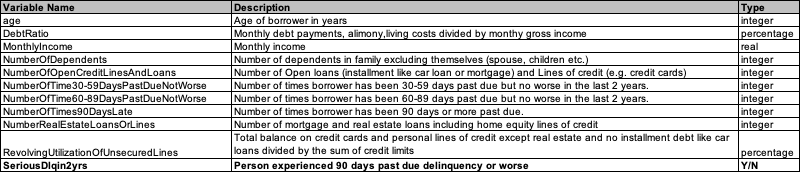

## Read Data

In [95]:
train_df = pd.read_csv(TRAIN_PATH, index_col='Unnamed: 0')
test_df = pd.read_csv(TEST_PATH, index_col='Unnamed: 0')
valid_df = pd.read_csv(VALID_PATH)

In [96]:
target = 'serious_dlqin_2yrs'
feature_list = train_df.columns.drop(target).tolist()

# Data Cleaning
Since some of the feature is not impacted by train test split, it's best to actually put it together

In [97]:
df = pd.concat([train_df, test_df])

In [98]:
mask = df.debt_ratio > 100 
print(f'Debt Ratio > 100: {mask.sum()} records')
print(f"Out of these records, missing monthly income: {df.loc[mask, 'monthly_income'].isna().sum()} records")

Debt Ratio > 100: 24380 records
Out of these records, missing monthly income: 22693 records


Based on this we can almost fill in most of the monthly income missing values

On a common sense basis, we knew that monthly_income > debt_ratio > revolving_utilization_of_unsecured_lines.
So we can already fill partially on the missing values and also 0 income value.

In [99]:
col_list = [
    'revolving_utilization_of_unsecured_lines',
    'monthly_income',
    'debt_ratio',
]
df.loc[:, 'monthly_income_max'] = df.loc[:, col_list].max(axis=1)
valid_df.loc[:, 'monthly_income_max'] = valid_df.loc[:, col_list].max(axis=1)

In [100]:
col_list = [
    'revolving_utilization_of_unsecured_lines',
    'debt_ratio',
]
for col in col_list:
  df.loc[:, f'{col}_impute'] = df.loc[:, col].copy(deep=True)
  valid_df.loc[:, f'{col}_impute'] = valid_df.loc[:, col].copy(deep=True)

In [101]:
col_list = [
    'revolving_utilization_of_unsecured_lines',
    'monthly_income',
    'debt_ratio',
    'monthly_income_max',
]

max_list = [
    'revolving_utilization_of_unsecured_lines',
    'debt_ratio'
]

mask = df.monthly_income_max == df.loc[:, max_list].max(axis=1)
df.loc[mask, 'debt_ratio_impute'] = np.where(
    df.loc[mask, 'monthly_income_max'] == df.loc[mask, 'debt_ratio'],
    0,
    df.loc[mask, 'debt_ratio']
)

df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] = np.where(
    df.loc[mask, 'monthly_income_max'] == df.loc[mask, 'revolving_utilization_of_unsecured_lines'],
    0,
    df.loc[mask, 'revolving_utilization_of_unsecured_lines']
)

In [102]:
mask = df.loc[:, 'debt_ratio_impute'] > 100
df.loc[mask, 'debt_ratio_impute'] = df.loc[mask, 'debt_ratio_impute'] / df.loc[mask, 'monthly_income_max']

In [103]:
mask = df.loc[:, 'revolving_utilization_of_unsecured_lines_impute'] > 100
df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] = df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] / df.loc[mask, 'monthly_income_max']

In [104]:
mask = df.loc[:, 'revolving_utilization_of_unsecured_lines_impute'] > 1
df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] = df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] / 100

mask = df.loc[:, 'debt_ratio_impute'] > 1
df.loc[mask, 'debt_ratio_impute'] = df.loc[mask, 'debt_ratio_impute'] / 100

In [105]:
col_list = [
    'monthly_income_max',
    'debt_ratio_impute',
    'revolving_utilization_of_unsecured_lines_impute'
]
df.loc[:, col_list].describe()

,monthly_income_max,debt_ratio_impute,revolving_utilization_of_unsecured_lines_impute
count,1.500000e+05,150000.000000,150000.000000
mean,5.702411e+03,0.231466,0.292643
std,1.316707e+04,0.233740,0.333782
min,0.000000e+00,0.000000,0.000000
25%,2.400000e+03,0.004051,0.024074
50%,4.500000e+03,0.186702,0.131899
75%,7.450000e+03,0.378925,0.496478
max,3.008750e+06,1.000000,1.000000


## Manual replacing

In [106]:
col_list = [
    'revolving_utilization_of_unsecured_lines',
    'monthly_income',
    'debt_ratio',
    'monthly_income_max',
]

max_list = [
    'revolving_utilization_of_unsecured_lines',
    'debt_ratio'
]

mask = valid_df.monthly_income_max == valid_df.loc[:, max_list].max(axis=1)
valid_df.loc[mask, 'debt_ratio_impute'] = np.where(
    valid_df.loc[mask, 'monthly_income_max'] == valid_df.loc[mask, 'debt_ratio'],
    0,
    valid_df.loc[mask, 'debt_ratio']
)

valid_df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] = np.where(
    valid_df.loc[mask, 'monthly_income_max'] == valid_df.loc[mask, 'revolving_utilization_of_unsecured_lines'],
    0,
    valid_df.loc[mask, 'revolving_utilization_of_unsecured_lines']
)

mask = valid_df.loc[:, 'debt_ratio_impute'] > 100
valid_df.loc[mask, 'debt_ratio_impute'] = valid_df.loc[mask, 'debt_ratio_impute'] / valid_df.loc[mask, 'monthly_income_max']
mask = valid_df.loc[:, 'debt_ratio_impute'] > 1
valid_df.loc[mask, 'debt_ratio_impute'] = valid_df.loc[mask, 'debt_ratio_impute'] / 100


mask = valid_df.loc[:, 'revolving_utilization_of_unsecured_lines_impute'] > 100
valid_df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] = valid_df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] / valid_df.loc[mask, 'monthly_income_max']
mask = valid_df.loc[:, 'revolving_utilization_of_unsecured_lines_impute'] > 1
valid_df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] = valid_df.loc[mask, 'revolving_utilization_of_unsecured_lines_impute'] / 100



In [107]:
col_list_imputed = [
    'monthly_income_max',
    'debt_ratio_impute',
    'revolving_utilization_of_unsecured_lines_impute'
]

In [108]:
new_feature_list = df.columns.drop(target).to_list()

index_list = train_df.index.tolist()
train_df = df.loc[index_list].copy(deep=True)

index_list = test_df.index.tolist()
test_df = df.loc[index_list].copy(deep=True)

# Feature Engineering

In [109]:

x_train = train_df.loc[:, new_feature_list].copy(deep=True)
y_train = train_df.loc[:, target].copy(deep=True)

x_test = test_df.loc[:, new_feature_list].copy(deep=True)
y_test = test_df.loc[:, target].copy(deep=True)

x_valid = valid_df.loc[:, new_feature_list].copy(deep=True)

## Binning

In [110]:
selection_criteria = {
    'iv': {'min':0.02, 'max':1},
    'quality_score':{'min':0.01}
}

binning_process = BinningProcess(new_feature_list,
                                 selection_criteria=selection_criteria,
                                 )
binning_process.fit(x_train, y_train)
metric = 'indices'

x_train_cat = binning_process.transform(x_train, metric=metric).astype('category')
x_test_cat = binning_process.transform(x_test, metric=metric).astype('category')
x_valid_cat = binning_process.transform(x_valid, metric=metric).astype('category')

bin_df = binning_process.summary()

In [111]:
bin_df.sort_values(by='name')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
1,age,numerical,OPTIMAL,True,11,0.254969,0.030877,0.265721,0.62012
3,debt_ratio,numerical,OPTIMAL,True,8,0.08389,0.010377,0.149926,0.250058
12,debt_ratio_impute,numerical,OPTIMAL,True,5,0.053031,0.006574,0.115985,0.16693
4,monthly_income,numerical,OPTIMAL,True,9,0.083249,0.010338,0.162791,0.1471
10,monthly_income_max,numerical,OPTIMAL,True,11,0.059765,0.007434,0.135899,0.03068
9,number_of_dependents,numerical,OPTIMAL,True,4,0.034177,0.004261,0.096592,0.09781
5,number_of_open_credit_lines_and_loans,numerical,OPTIMAL,False,9,0.076789,0.009453,0.132034,0.004291
2,number_of_time_30_59_days_past_due_not_worse,numerical,OPTIMAL,True,3,0.718946,0.082872,0.372145,0.201851
8,number_of_time_60_89_days_past_due_not_worse,numerical,OPTIMAL,True,2,0.548173,0.059703,0.234785,0.111133
6,number_of_times_90_days_late,numerical,OPTIMAL,True,2,0.798187,0.085144,0.30266,0.060769


# Summary on Feature Engineering
Seems like some of the features improve.
- the one with suspicious high IV
  - revolving utilization of unsecured line impute is now below than 1
  - debt_ratio impute is lower but it's possibly due to the lower number of bins
  - monthly income impute is probably not as good as original monthly income

# Model

In [112]:
selection_criteria = {
    'iv': {'min':0.02, 'max':1},
    'quality_score':{'min':0.01}
}

binning_process = BinningProcess(new_feature_list,
                                 selection_criteria=selection_criteria,
                                 )

model = LogisticRegression(solver='lbfgs', 
                           class_weight='balanced', 
                           random_state=SEED
                           )
pipeline = Pipeline(steps=[('binning_process', binning_process),
                           ('logistic_regression', model),
                           ])

pipeline.fit(x_train, y_train)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)

## Feature Importance

/usr/local/lib/python3.9/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/yellowbrick/model_selection/importances.py:194: YellowbrickWarning: detected multi-dimensional feature importances but stack=False, using mean to aggregate them.
  warnings.warn(


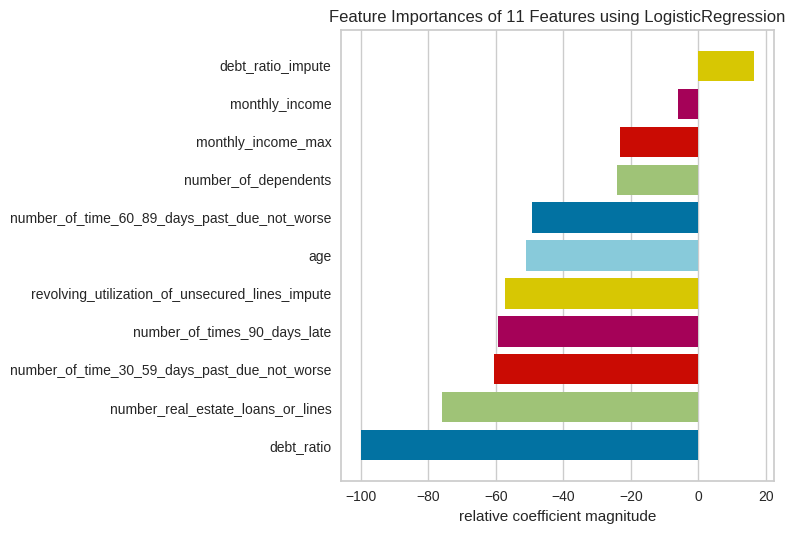

In [113]:
viz = FeatureImportances(pipeline.get_params().get('steps')[1][1], relatives=False)
viz.fit(x_train_cat, y_train)
viz.show()
plt.show()

In [114]:
y_pred = pipeline.predict_proba(x_train)[:, 1]

## Train AUC

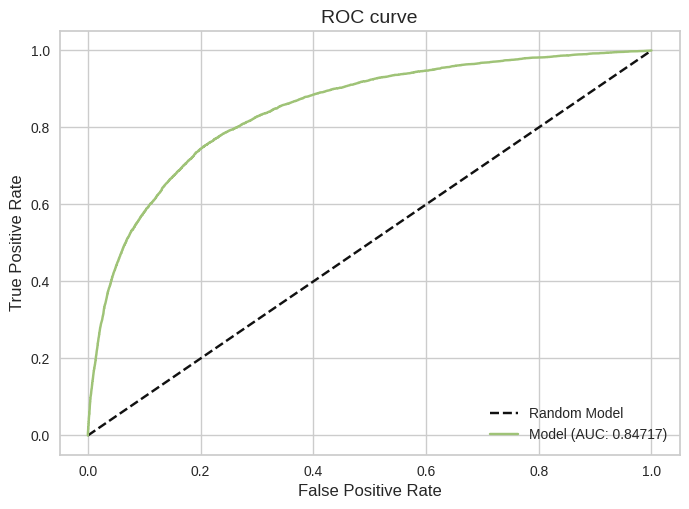

In [115]:
plot_auc_roc(y_train, y_pred)

## Train CAP

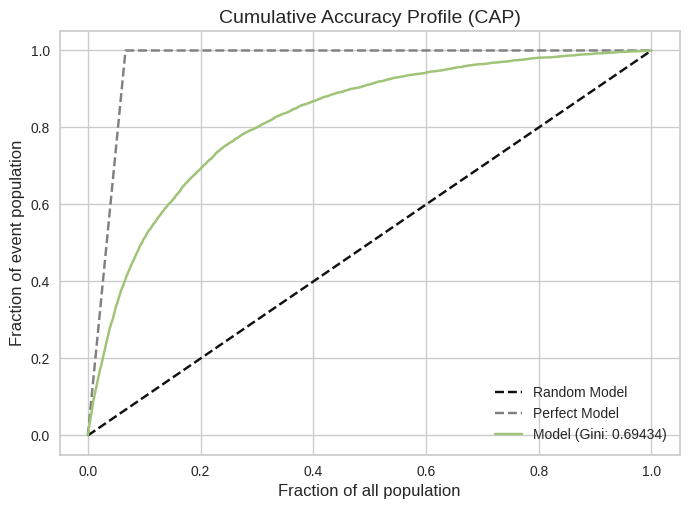

In [116]:
plot_cap(y_train, y_pred)

## Train KS

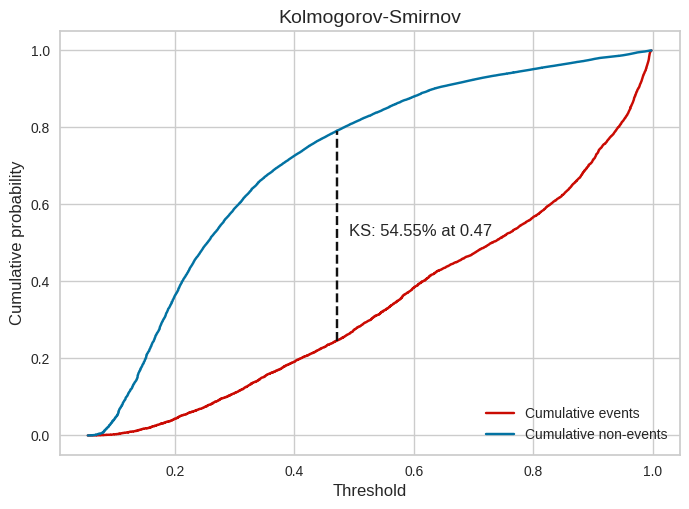

In [117]:
plot_ks(y_train, y_pred)

## Summary on Train Performance
- AUC: 0.84
- Gini: 0.69
- Max KS (54.55) at threshold 0.47

## Bucket Evaluation on Train Data

In [118]:
bucket_evaluation(y_pred_prob=y_pred, y_true=y_train, bucket=10)

,event,total,lower_limit,upper_limit,cumulative_event,cumulative_total,capture_rate,event_rate
bins,,,,,,,,
1,56,10525,0.053957,0.121099,56,10525,0.007977,0.005321
2,77,10486,0.121099,0.153707,133,21011,0.018946,0.007343
3,115,10489,0.153707,0.185824,248,31500,0.035328,0.010964
4,157,10503,0.185824,0.221781,405,42003,0.057692,0.014948
5,217,10497,0.221781,0.268355,622,52500,0.088604,0.020673
6,303,10502,0.268355,0.325143,925,63002,0.131766,0.028852
7,477,10512,0.325143,0.409597,1402,73514,0.199715,0.045377
8,756,10489,0.409597,0.532228,2158,84003,0.307407,0.072076
9,1262,10497,0.532228,0.716191,3420,94500,0.487179,0.120225


## Conclusion on Bucket Evaluation on Train Data
Based on the theshold = 0.47, we can cover about 70% to 80% of the payers (bins no.8) where we only capture 19% (23%) to 30% (32%) of the bad payer.

- It's definitely better than the previous model in training performance.

- The percentage in bracket indicates for the baseline model.

## Bucket Evaluation on Test Data

In [119]:
y_pred = pipeline.predict_proba(x_test)[:, 1]
bucket_evaluation(y_pred_prob=y_pred, y_true=y_test, bucket=10)

,event,total,lower_limit,upper_limit,cumulative_event,cumulative_total,capture_rate,event_rate
bins,,,,,,,,
1,24,4502,0.054494,0.120690,24,4502,0.007984,0.005331
2,36,4532,0.120690,0.152746,60,9034,0.019960,0.007944
3,37,4481,0.152746,0.184723,97,13515,0.032269,0.008257
4,76,4487,0.184723,0.220125,173,18002,0.057552,0.016938
5,77,4499,0.220125,0.265291,250,22501,0.083167,0.017115
6,112,4500,0.265291,0.323005,362,27001,0.120426,0.024889
7,173,4499,0.323005,0.406395,535,31500,0.177977,0.038453
8,303,4500,0.406395,0.529854,838,36000,0.278776,0.067333
9,527,4500,0.529854,0.719818,1365,40500,0.454092,0.117111


## Conclusion on Bucket Evaluation on Test Data
Based on the theshold = 0.47, we still can cover about 70% to 80% of the payers (bins no.8) where we only capture 17%(21%) to 27%(30%) of the bad payer.

It does not give huge difference though compared to the train performance which meant it's relatively stable.

- The percentage in bracket indicates for the baseline model

## Typical Metric Evaluation

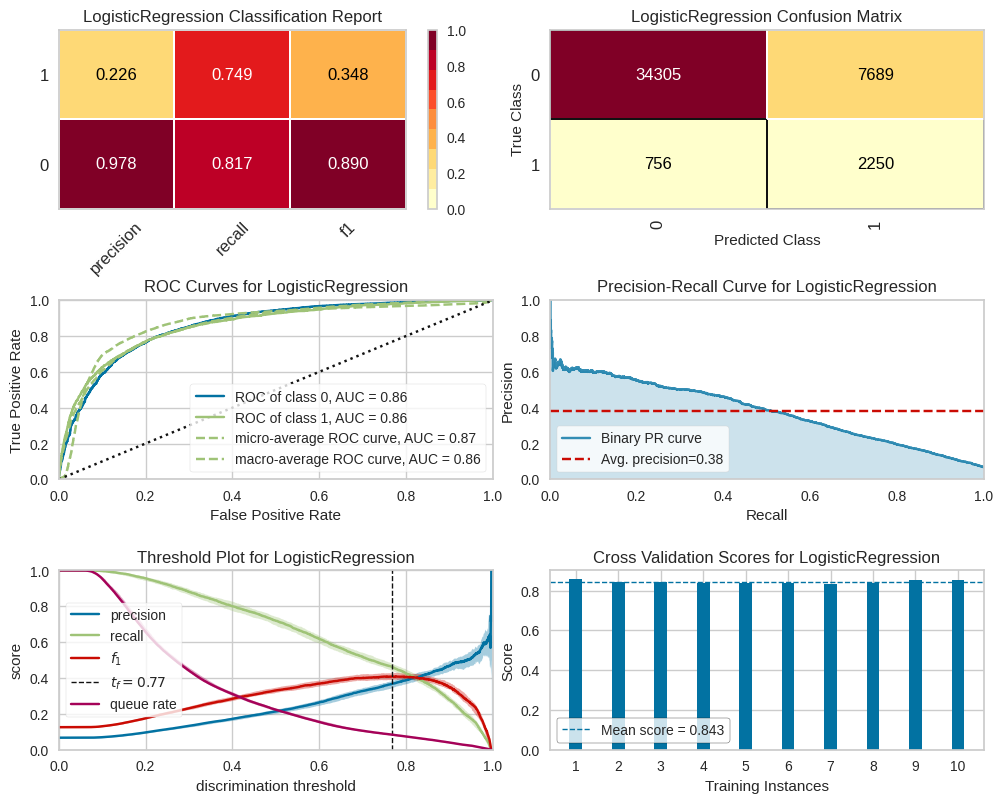

In [120]:
classifier_evaluation(pipeline, x_train, y_train, x_test, y_test, cv, 'roc_auc')

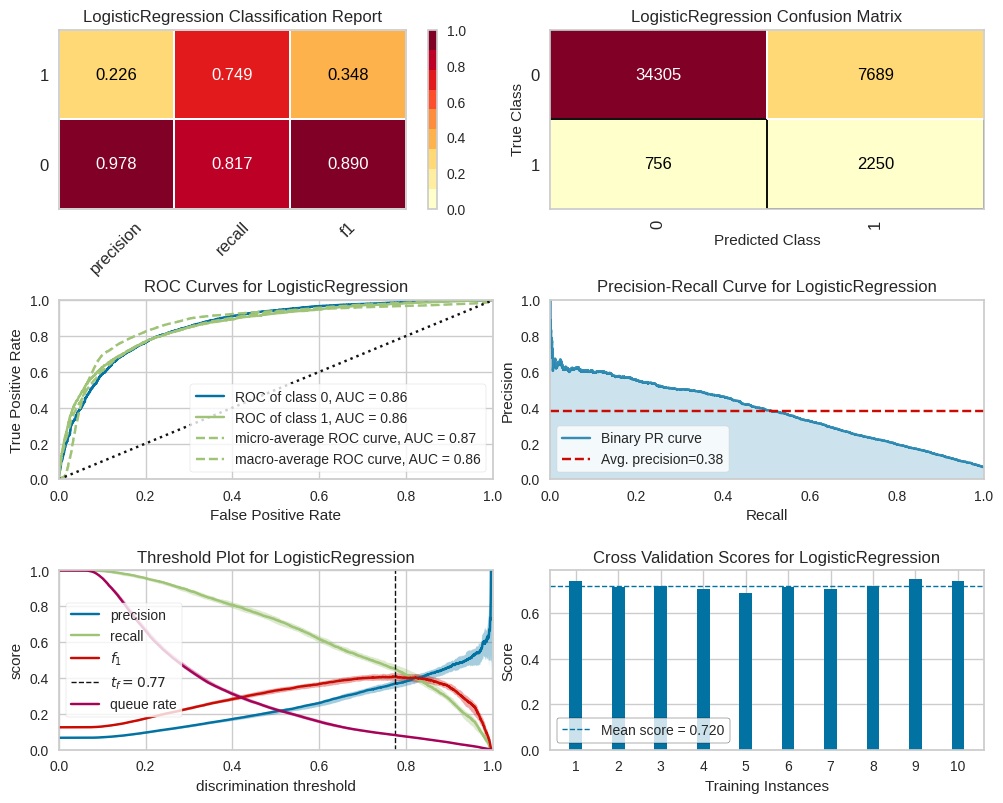

In [121]:
classifier_evaluation(pipeline, x_train, y_train, x_test, y_test, cv, 'recall')

## Summary
- AUC: 0.86 (difference between micro and macro is not that huge)
- Based on the confusion matrix, it's advised to calculate the potential profit that we are losing and potential loss we will incur.
- The discrimination theshold is about 0.77, which meant we should not offer any loan if it exceed 0.77, which in bucket evaluation it will be our last bin (bins no. 10)
- CV: 0.84 on average but more than 0.8 (stable performance as expected. Since Logistic Regression suppose to have less variance and more bias)
- CV Recall: 0.72 on average
- Based on the metric, even though confusion matrix is showing somewhat a weird value but it's possibly due to threshold setup.
- Hence, looking at the recall metric wise, it's improved compared to the previous chart.

# Output

In [128]:
x_train_cat.index = train_df.index
x_test_cat.index = test_df.index
x_valid_cat.index = valid_df.index

In [129]:
if OUTPUT:

  train_df.to_csv(f'{OUTPUT_DIR}04-feature_engineering_lr_model-train_df.csv')
  test_df.to_csv(f'{OUTPUT_DIR}04-feature_engineering_lr_model-test_df.csv')

  train_df_cat = pd.concat([x_train_cat, y_train], axis=1)
  test_df_cat = pd.concat([x_test_cat, y_test], axis=1)
  valid_df_cat = x_valid

  train_df_cat.to_csv(f'{OUTPUT_DIR}04-feature_engineering_lr_model-train_df_cat.csv')
  test_df_cat.to_csv(f'{OUTPUT_DIR}04-feature_engineering_lr_model-test_df_cat.csv')
  valid_df_cat.to_csv(f'{OUTPUT_DIR}04-feature_engineering_lr_model-valid_df_cat.csv')

  joblib.dump(pipeline, f'{OUTPUT_DIR}04-feature_engineering_lr_model-pipeline.pkl')